At this point R must be installed and this Py_notebook must recognize R (blue simbol upper right)
then make sure you install or have installed the following packages.

In [1]:
#install.packages("vioplot", repo = "https://lib.ugent.be/CRAN/")
#help(package = "package")
#packageDescription("package")

install.packages("viridis", repo = "https://cran.rstudio.com/bin/windows/contrib/3.5/viridis_0.5.1.zip")
install.packages("rasterVis", repo = "https://cran.rstudio.com/bin/windows/contrib/3.5/rasterVis_0.45.zip")
install.packages("raster")
install.packages("rgdal")
install.packages("viridisLite")
install.packages("reshape", repo ="https://cran.rstudio.com/bin/windows/contrib/3.5/reshape_0.8.8.zip")



Installing package into 'C:/Users/janaya/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
Warning message:
"unable to access index for repository https://cran.rstudio.com/bin/windows/contrib/3.5/viridis_0.5.1.zip/src/contrib:
  no fue posible abrir la URL 'https://cran.rstudio.com/bin/windows/contrib/3.5/viridis_0.5.1.zip/src/contrib/PACKAGES'"Warning message:
"package 'viridis' is not available (for R version 3.5.1)"Warning message:
"unable to access index for repository https://cran.rstudio.com/bin/windows/contrib/3.5/viridis_0.5.1.zip/bin/windows/contrib/3.5:
  no fue posible abrir la URL 'https://cran.rstudio.com/bin/windows/contrib/3.5/viridis_0.5.1.zip/bin/windows/contrib/3.5/PACKAGES'"Installing package into 'C:/Users/janaya/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
Warning message:
"unable to access index for repository https://cran.rstudio.com/bin/windows/contrib/3.5/rasterVis_0.45.zip/src/contrib:
  no fue posible abrir la URL 'https://cran.rstudio.com/bin/

ERROR: Error in contrib.url(repos, "source"): trying to use CRAN without setting a mirror


httr is needed for submitting requests and interact with the web server, the answer of the server must be converted into a familiar structure, here we use jsonlite.  ggplot, scales and viridis are requerid for plotting

In [2]:
# Web service interaction:
library(httr)
library(jsonlite)

# Plots:
library(reshape)
library(ggplot2)
library(scales)
library(viridis)
require(gridExtra)


# Rasters:
library(raster)
library(rasterVis)

options(warn=-1)

Warning message:
"package 'httr' was built under R version 3.5.3"Warning message:
"package 'jsonlite' was built under R version 3.5.3"Warning message:
"package 'reshape' was built under R version 3.5.3"Warning message:
"package 'ggplot2' was built under R version 3.5.3"Warning message:
"package 'scales' was built under R version 3.5.3"Warning message:
"package 'viridis' was built under R version 3.5.3"Loading required package: viridisLite
Warning message:
"package 'viridisLite' was built under R version 3.5.3"
Attaching package: 'viridis'

The following object is masked from 'package:scales':

    viridis_pal

Loading required package: gridExtra
Warning message:
"package 'gridExtra' was built under R version 3.5.3"Warning message:
"package 'raster' was built under R version 3.5.3"Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.5.3"Warning message:
"package 'rasterVis' was built under R version 3.5.3"Loading required package: lattice
Loading requi

200 means that we got a response from the server. Note that a list called "response" is created using "GET", base on products info of the web page, it creates a list of the "products" available at the web page.

In [3]:
url <- "https://modis.ornl.gov/rst/api/v1/"

response <- GET("https://modis.ornl.gov/rst/api/v1/products")
http_status(response)$message

[1] "Success: (200) OK"

Here there is a list of the product number 27, which correspond to the VNP13A1 product

In [4]:
products <- content(response)$products
typeof(products)
products[26:27]

[1] "list"

[[1]]
[[1]]$product
[1] "VNP09H1"

[[1]]$description
[1] "VIIRS/S-NPP Surface Reflectance (SREF) 8-Day L3 Global 500m SIN Grid"

[[1]]$frequency
[1] "8-Day"

[[1]]$resolution_meters
[1] 500


[[2]]
[[2]]$product
[1] "VNP13A1"

[[2]]$description
[1] "VIIRS/S-NPP Vegetation Indices (NDVI/EVI) 16-Day L3 Global 500m SIN Grid"

[[2]]$frequency
[1] "16-Day"

[[2]]$resolution_meters
[1] 500

Now define the location for the time series, there is a iteration of ten modis dates to avoid web server timing out.  This is the "date" function where the first 10 dates of VIIRS data is shown

In [5]:
# Set dates request parameters
prod <- 'VNP13A1'   # MODIS product  #note that this is VIIRS data, but this is a minor error along the code.
lat <- 35.71326     # Input latitude
lon <- -83.51047    # Input longitude

r <- GET(paste0("https://modis.ornl.gov/rst/api/v1/",prod,"/dates?latitude=",lat,"&longitude=",lon)) # Get dates response
dates <- content(r)$dates # Parse response object to list
modis_dates <- unlist(lapply(dates, function(dt) dt$modis_date)) # Split list of lists into list of modis date strings
calendar_dates <- as.Date(unlist(lapply(dates, function(dt) dt$calendar_date))) # and also into R date objects
doys <- substr(modis_dates,start=6,stop=8) # Also get a list of days of the year

# Print the first ten modis dates
paste(modis_dates[1:10])  

[1] "A2012017" "A2012025" "A2012033" "A2012041" "A2012049" "A2012057"
 [7] "A2012065" "A2012073" "A2012081" "A2012089"

url, prod, lat, lon were defined above, now other variables are defined as data band, QC band and a buffer around the lat,lon center previously defined.  Start date and end date (modis_dates) are also needed to subset spatial data, note the $subset below, it has 81 numbers since we have 9 files and 9 columns.  Also note that "scale" is needed to change from integers to floats.  Here we are building a request GET to the web server.

In [6]:
# Set the remaining subset request parameters
data_band <- '500_m_16_days_EVI2'        # Daytime EVI2 band name
qc_band <- '500_m_16_days_VI_Quality'    # Daytime QC band name
above_below <- 2                         # km above/below
left_right <- 2                          # km left/right

requestURL <- function(latitude, longitude, product, band, start_date, end_date, kmAB, kmLR){
    return(
        paste0(
            url,product,"/subset?",
            "latitude=",latitude,
            "&longitude=",longitude,
            "&band=",band,
            "&startDate=",start_date,
            "&endDate=",end_date,
            "&kmAboveBelow=",kmAB,
            "&kmLeftRight=",kmLR
        )
    )
}

r <- GET(requestURL(lat, lon, prod, data_band, modis_dates[1], modis_dates[1], above_below, left_right))
subset <- fromJSON(toJSON(content(r)))
subset

modis_date,calendar_date,band,tile,proc_date,data
A2012017,2012-01-17,500_m_16_days_EVI2,h11v05,2018137160532,"1920, 2032, 2042, 1744, 1887, 1588, 1588, 1932, 2154, 2048, 1778, 1448, 1493, 1493, 1388, 1698, 2326, 2385, 1593, 1772, 1593, 2186, 1779, 1519, 1760, 2001, 2375, 1922, 2152, 2090, 2090, 1554, 1720, 2169, 1954, 2244, 1497, 1497, 1778, 2060, 1421, 1372, 1501, 1757, 1106, 2426, 2239, 2235, 1814, 1697, 1653, 1621, 1577, 1417, 1812, 1576, 1473, 1686, 2385, 2876, 2059, 2059, 1997, 1767, 2030, 1809, 1694, 900, 1354, 2570, 2024, 1905, 1958, 1958, 2643, 1569, 1128, 1851, 2955, 3292, 2222"


Here few variables are created with the metadata just listed.  This will be used later. csv stands for Comma Separated Values.  note the use of "as.integer" and "as.double".

In [7]:
nrow <- as.integer(subset$nrow)             # number of rows
ncol <- as.integer(subset$ncol)             # number of columns
xllcorner <- as.double(subset$xllcorner)    # lower left hand corner x-coordinate
yllcorner <- as.double(subset$yllcorner)    # lower left hand corner y-coordinate
cellsize <- as.double(subset$cellsize)      # pixel size
scale <- as.double(subset$scale)            # scale factor

cat(
    "Row count: ",nrow,
    "\nCol count: ",ncol,
    "\nLower left X: ",xllcorner,
    "\nLower left Y: ",yllcorner,
    "\nPixel size: ",cellsize,
    "\nScale factor: ",scale
)

Row count:  9 
Col count:  9 
Lower left X:  -7541804 
Lower left Y:  3969200 
Pixel size:  463.3127 
Scale factor:  1e-04

Now the 81 cells from 2012017 are listed in a row.  So each file is a data and each column is a pixel.

In [8]:
# Get subset$subset$data as a new data frame and transpose so that rows are timesteps and columns are pixels
format_subset <- t(as.data.frame(subset$subset$data, col.names=subset$subset$modis_date, check.names=FALSE))
format_subset <- format_subset*as.numeric(scale)
format_subset

A2012017,0.192,0.2032,0.2042,0.1744,0.1887,0.1588,0.1588,0.1932,0.2154,0.2048,...,0.1905,0.1958,0.1958,0.2643,0.1569,0.1128,0.1851,0.2955,0.3292,0.2222


Now we want to create a raster with the list and visualize it as a matrix.  Note in the last two lines of the next code block the result can be printed as TIFF files with their associated projection.

class       : RasterLayer 
dimensions  : 9, 9, 81  (nrow, ncol, ncell)
resolution  : 463.3127, 463.3127  (x, y)
extent      : -7541804, -7537635, 3969200, 3973370  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs 
data source : in memory
names       : layer 
values      : 0.09, 0.3292  (min, max)


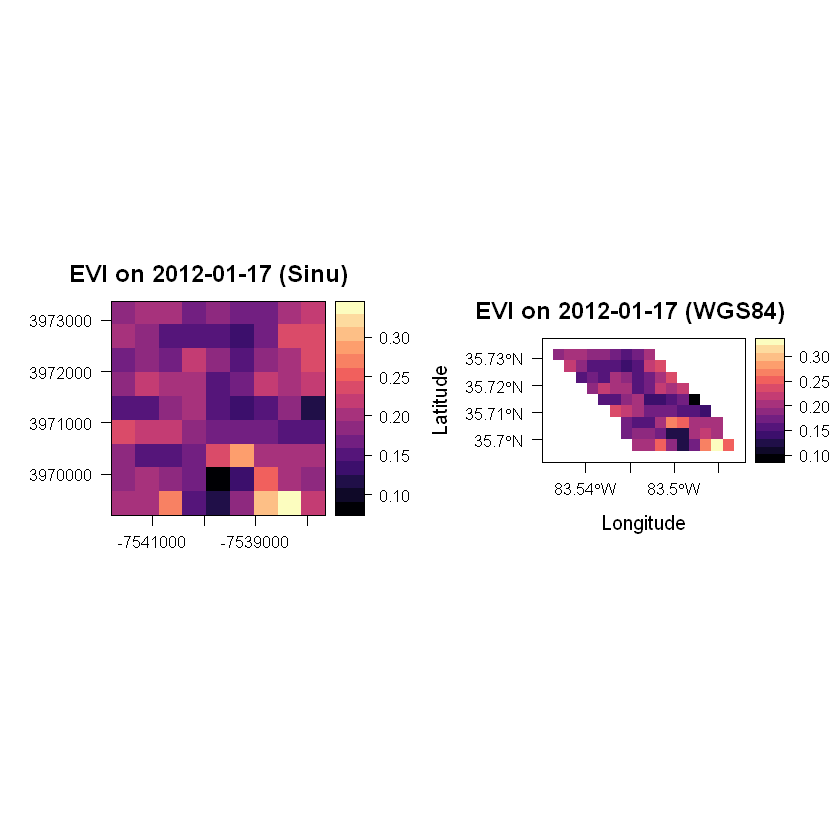

In [9]:
# Make function to create raster objects
r_template <- function(vals, nrow,ncol,xllcorner,yllcorner,cellsize){
    return(
        raster(
            vals = vals,
            nrows = nrow,
            ncols = ncol,
            xmn = xllcorner,
            xmx = xllcorner + (ncol*cellsize),
            ymn = yllcorner,
            ymx = yllcorner + (nrow*cellsize),
            crs = '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ',
            resolution = cellsize 
        )
    )
}

# Use subset metadata and the new function to make raster object
r_subset <- r_template(format_subset, nrow, ncol, xllcorner, yllcorner, cellsize)
# Warp to WGS84 as another raster object
r_subset_wgs84 <- projectRaster(r_subset, crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ')

# Plot both with rasterVis::levelplot
r_ras1 <- levelplot(r_subset, main = paste0("EVI on ",subset$subset$calendar_date," (Sinu)"), margin = FALSE)
r_ras2 <- levelplot(r_subset_wgs84, main = paste0("EVI on ",subset$subset$calendar_date," (WGS84)"), margin = FALSE)

r_subset # Print raster (sinu) details
grid.arrange(r_ras1, r_ras2, ncol=2) # Display raster grids with gridExtra::grid.arrange

# Save raster objects as GeoTIFFs
#writeRaster(r_subset,'sinu_subset.tif',options=c('COMPRESS=LZW'))
#writeRaster(r_subset_wgs84,'wgs84_subset.tif',options=c('COMPRESS=LZW'))

This code is to iterate through the dates, 10 dates limit, and built the time series by "append". There are two files, one per product, i.e. one for EVI data and another for quality data i.e QCdata

In [10]:
# Initialize response data.frames to store the returned EVI and QC data
proddata <- data.frame()
qcdata <- data.frame()

# Iterate through the list of dates and submit subset requests.
for (dt in modis_dates){
    
    # Submit request and append to EVI time series
    r <- GET(requestURL(lat, lon, prod, data_band, dt, dt, above_below, left_right))
    subset <- fromJSON(toJSON(content(r)))
    proddata <- rbind(proddata, subset$subset)
    
    # Submit request and append to QC time series
    r <- GET(requestURL(lat, lon, prod, qc_band, dt, dt, above_below, left_right))
    qcsubset <- fromJSON(toJSON(content(r)))
    qcdata <- rbind(qcdata, qcsubset$subset)

}

Now we use ggplot, to plot the time series

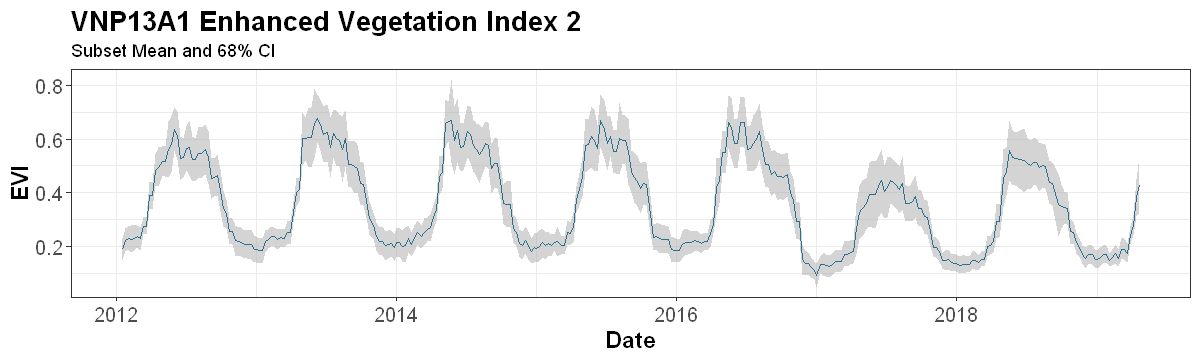

In [11]:
# Make subset data "CSV-like":
prodvalues <- t(as.data.frame(proddata$data, col.names=proddata$calendar_date, check.names=FALSE))
prodvalues <- prodvalues*as.numeric(scale) # Apply scale factor

prodstats <- data.frame( # prodstats data frame is passed to ggplot
    date = as.Date(unlist(calendar_dates)), # get formatted dates from calendar_dates list (strings)
    mean = rowMeans(prodvalues, na.rm=TRUE), # get mean of each row (timestep)
    sd = apply(prodvalues, 1, sd, na.rm = TRUE) # and standard deviation 
)

plot <- ggplot(prodstats) +

    # Plot mean (geom_line) and standard deviation (geom_ribbon)
    geom_ribbon(aes(ymin=prodstats$mean - prodstats$sd, ymax=prodstats$mean + prodstats$sd , x=date), fill = 'darkgray', alpha = 0.5) + # draw the shaded area for 68% CI
    geom_line(aes(y=mean, x=date), colour = '#2D708EFF') + # draw the line for the mean value 

    # Label and make the plot pretty:
    labs(title = 'VNP13A1 Enhanced Vegetation Index 2', subtitle = 'Subset Mean and 68% CI') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements

options(repr.plot.width = 10, repr.plot.height = 3)
plot

Note that the first date corresponds to the first VIIRS date available to the most recent processed date.  Now list both the EVI and the QC

In [12]:
# Create "CSV-like" data frames (prodvalues & qcvalues)
prodvalues <- t(as.data.frame(proddata$data, col.names=proddata$calendar_date, check.names=FALSE))
qcvalues <- t(as.data.frame(qcdata$data, col.names=qcdata$calendar_date, check.names=FALSE))

# Get a vector of unique values from the QC layer time series
qcvals <- sort(unique(c(qcvalues)))
print(paste('These are the unique QC values: ', paste(sort(qcvals), collapse=', '), sep = ''), quote = FALSE)
head(prodvalues,5)
head(qcvalues,5)

[1] These are the unique QC values: 2061, 2065, 2116, 2120, 2124, 2185, 2189, 2257, 2261, 2325, 2445, 2517, 2521, 3358, 3362, 3366, 3418, 18713, 34893, 34961, 34965, 35033, 35037, 35097, 35101, 35105, 35157, 35221, 35225, 35293, 35297, 51229, 51485, 51489, 51493


2012-01-17,1920,2032,2042,1744,1887,1588,1588,1932,2154,2048,...,1905,1958,1958,2643,1569,1128,1851,2955,3292,2222
2012-01-25,2389,2346,2687,2071,2110,2233,2020,2116,2080,2256,...,2856,2151,2434,2643,1569,1755,1851,2955,3292,2222
2012-02-02,2389,2346,2693,2071,2110,2233,2190,2352,2352,2256,...,2856,2151,2434,2734,2955,1755,1944,2870,3422,2685
2012-02-10,2337,2567,2693,2293,2323,2009,2190,2352,2352,2609,...,2811,1617,2655,2646,1571,619,2369,3265,3023,2521
2012-02-18,2280,2506,2684,2293,2223,1791,1644,1903,2444,2509,...,2811,2491,2785,2646,1571,619,2627,3034,3023,2521


2012-01-17,2116,2116,2116,2116,2116,2116,2116,2116,2120,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
2012-01-25,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
2012-02-02,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
2012-02-10,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2120,2116,2116,2116,2116,2116,2116,2116,2116
2012-02-18,2116,2116,2116,2116,2116,2120,2120,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116


qc, good scientists are always concerned by the quality of the data.  Understanding the meaning of the values in the QC layer: we need to understand the meaning of each unique QC value.

An empty table is created with several columns associated to the unique QC values listed above. One column for the unique layer QC value, 16 columns for the bits, and 9 columns for each QC group.

In [13]:
QC_Data <- data.frame(
    
    # A column with one row for each unique integer value in the QC layer time series
    Integer_Value = qcvals, 
    
    # An empty column for each bit 
    Bit15 = NA, Bit14 = NA, Bit13 = NA, Bit12 = NA, Bit11 = NA, Bit10 = NA, Bit9 = NA, Bit8 = NA, 
    Bit7 = NA, Bit6 = NA, Bit5 = NA, Bit4 = NA, Bit3 = NA, Bit2 = NA, Bit1 = NA, Bit0 = NA, 
    
    # An empty column for each QC group (9 groups)
    MODLAND_QA = NA, VI_usefulness = NA, Aerosol_quantity = NA, Adjacent_cloud_detected = NA,
    Atmosphere_BRDF_correction_performed = NA, Mixed_clouds = NA, Land_Water_flag = NA, 
    Possible_snow_ice = NA, Possible_shadow = NA

)

head(QC_Data, 5)

Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
2061,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2065,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2116,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2120,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2124,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Note that each EVI pixel has a corresponding QC value from the list above that came from the ORNL site.  Each value from the QC layer has a meaning that we don't know yet.  
Note that if all the bits have zero value, it means that the pixel is perfect for the TS, it correspond to the first line of the 9 groups.  There is a total of 39 possible QC values (flags or quality issues) located in 9 groups.

One line from each group is needed to complete a 16bits byte.

Loop through each row from the empty table to get the binary representation of each integer value, and populate the empty (NA) table (above) with the 16-bit columns with a 0 or a 1, the next list is populated as (strictly) defined by MODIS/VIIRS team.  Once the table is populated we will see the meaning of each QC value in each of the 9 groups.

In [14]:
# Loop through each QC integer and populate the QC bit columns with 0s and 1s
for(i in seq(1,length(QC_Data$Integer_Value),1)){
    AsInt <- as.integer(intToBits(QC_Data[i,])[1:16])
    QC_Data[i,2:17] <- AsInt[16:1] # Flip to big endian
}

# Describe the QC bits based on the criteria outlined in the MODIS product table
QC_Data$MODLAND_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0 == 0] <- 'VI produced, good quality'
QC_Data$MODLAND_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0 == 1] <- 'VI produced, but check other QA'
QC_Data$MODLAND_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0 == 0] <- 'Pixel produced, but most probably cloudy'
QC_Data$MODLAND_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0 == 1] <- 'Pixel not produced due to other reasons than clouds'

QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 1'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality Lv 2'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'Quality Lv 3'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Quality Lv 4'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 5'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality Lv 6'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'Quality Lv 7'
QC_Data$VI_usefulness[QC_Data$Bit5==0 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Quality Lv 8'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 9'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality Lv 10'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'Quality Lv 11'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==0 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Quality Lv 12'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==0] <- 'Quality Lv 13'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==0 & QC_Data$Bit2==1] <- 'Quality so low that it is not useful'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==0] <- 'L1B data faulty'
QC_Data$VI_usefulness[QC_Data$Bit5==1 & QC_Data$Bit4==1 & QC_Data$Bit3==1 & QC_Data$Bit2==1] <- 'Not useful for any other reason/not processed'

QC_Data$Aerosol_quantity[QC_Data$Bit7 == 0 & QC_Data$Bit6==0] <- 'Climatology'
QC_Data$Aerosol_quantity[QC_Data$Bit7 == 0 & QC_Data$Bit6==1] <- 'Low'
QC_Data$Aerosol_quantity[QC_Data$Bit7 == 1 & QC_Data$Bit6==0] <- 'Average'
QC_Data$Aerosol_quantity[QC_Data$Bit7 == 1 & QC_Data$Bit6==1] <- 'High'

QC_Data$Adjacent_cloud_detected[QC_Data$Bit8 == 0] <- 'No'
QC_Data$Adjacent_cloud_detected[QC_Data$Bit8 == 1] <- 'Yes'

QC_Data$Atmosphere_BRDF_correction_performed[QC_Data$Bit9 == 0] <- 'No'
QC_Data$Atmosphere_BRDF_correction_performed[QC_Data$Bit9 == 1] <- 'Yes'

QC_Data$Mixed_clouds[QC_Data$Bit10 == 0] <- 'No'
QC_Data$Mixed_clouds[QC_Data$Bit10 == 1] <- 'Yes'

QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 0 & QC_Data$Bit11 == 0] <- 'Land and desert'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 0 & QC_Data$Bit11 == 1] <- 'land no desert'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 1 & QC_Data$Bit11 == 0] <- 'inland water'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 0 & QC_Data$Bit12 == 1 & QC_Data$Bit11 == 1] <- 'sea water'
QC_Data$Land_Water_flag[QC_Data$Bit13 == 1 & QC_Data$Bit12 == 0 & QC_Data$Bit11 == 1] <- 'coastal'

QC_Data$Possible_snow_ice[QC_Data$Bit14 == 0] <- 'No'
QC_Data$Possible_snow_ice[QC_Data$Bit14 == 1] <- 'Yes'

QC_Data$Possible_shadow[QC_Data$Bit15 == 0] <- 'No'
QC_Data$Possible_shadow[QC_Data$Bit15 == 1] <- 'Yes'

head(QC_Data,5)

Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
2061,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 4,Climatology,No,No,No,land no desert,No,No
2065,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 5,Climatology,No,No,No,land no desert,No,No
2116,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 2,Low,No,No,No,land no desert,No,No
2120,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 3,Low,No,No,No,land no desert,No,No
2124,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 4,Low,No,No,No,land no desert,No,No


Now that the table has been populated, you can identify the combination of bits (groups) you might not want to include in your TS. Values that do not meet quality standards or quality criteria (invalid values).

The goal is to remove rows from the table that pass our quality criteria so we can use the remaining rows to mask our TS.  We need to define the flags not passing quality to build a mask!

The following filter contains the flags to exclude from the TS. It has 5 groups from the 9 groups available. Note that some QC have no "adjacent_cloud_detected" but they do not pass the VI_uselfulness, so are included in the final table, that will be used as a mask to identify and remove "invalid" values from the TS.

In [15]:
MODLAND_QA <- c('Pixel produced, but most probably cloudy','Pixel not produced due to other reasons than clouds')
VI_usefulness <- c("Quality Lv 4","Quality Lv 5","Quality Lv 6","Quality Lv 7","Quality Lv 8","Quality Lv 9","Quality Lv 10","Quality Lv 11","Quality Lv 12","Quality Lv 13",
                   "Quality so low that it is not useful","L1B data faulty","Not useful for any other reason/not processed")
Aerosol_quantity <- "High"
Adjacent_cloud_detected <- "Yes"
Possible_shadow <- "Yes"

QC_Data <- QC_Data[QC_Data$MODLAND_QA %in% MODLAND_QA | 
                    QC_Data$VI_usefulness %in% VI_usefulness | 
                    QC_Data$Aerosol_quantity == Aerosol_quantity | 
                    QC_Data$Adjacent_cloud_detected == Adjacent_cloud_detected |
                    QC_Data$Possible_shadow == Possible_shadow 
                   ,]
rownames(QC_Data) <- NULL
head(QC_Data,10)

Integer_Value,Bit15,Bit14,Bit13,Bit12,Bit11,Bit10,Bit9,Bit8,Bit7,...,Bit0,MODLAND_QA,VI_usefulness,Aerosol_quantity,Adjacent_cloud_detected,Atmosphere_BRDF_correction_performed,Mixed_clouds,Land_Water_flag,Possible_snow_ice,Possible_shadow
2061,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 4,Climatology,No,No,No,land no desert,No,No
2065,0,0,0,0,1,0,0,0,0,...,1,"VI produced, but check other QA",Quality Lv 5,Climatology,No,No,No,land no desert,No,No
2124,0,0,0,0,1,0,0,0,0,...,0,"VI produced, good quality",Quality Lv 4,Low,No,No,No,land no desert,No,No
2189,0,0,0,0,1,0,0,0,1,...,1,"VI produced, but check other QA",Quality Lv 4,Average,No,No,No,land no desert,No,No
2257,0,0,0,0,1,0,0,0,1,...,1,"VI produced, but check other QA",Quality Lv 5,High,No,No,No,land no desert,No,No
2261,0,0,0,0,1,0,0,0,1,...,1,"VI produced, but check other QA",Quality Lv 6,High,No,No,No,land no desert,No,No
2325,0,0,0,0,1,0,0,1,0,...,1,"VI produced, but check other QA",Quality Lv 6,Climatology,Yes,No,No,land no desert,No,No
2445,0,0,0,0,1,0,0,1,1,...,1,"VI produced, but check other QA",Quality Lv 4,Average,Yes,No,No,land no desert,No,No
2517,0,0,0,0,1,0,0,1,1,...,1,"VI produced, but check other QA",Quality Lv 6,High,Yes,No,No,land no desert,No,No
2521,0,0,0,0,1,0,0,1,1,...,1,"VI produced, but check other QA",Quality Lv 7,High,Yes,No,No,land no desert,No,No


In [16]:
filter <- QC_Data$Integer_Value # We will remove these values

for(tstep in seq(1, length(calendar_dates), by = 1)){ # Loop through timesteps
    filt <- which(qcvalues[tstep,] %in% filter) # Make mask from QC layer
    prodvalues[tstep,filt] <- NA # Set EVI columns to NA
    
}

The EVI time series is filtered now. 
Remember there are 81 EVI values for each date. The plot is the mean and standard deviation for each date.
Blue bars are the % of pixels that pass the quality criteria, 100% is 81
Quality Control is important because you do not want to build TS with poor quality pixels.  This happens in areas with rainy season.
The last of the 3 plots is the EVI stacked by year.  Showing low EVI year due to fire occurrence.

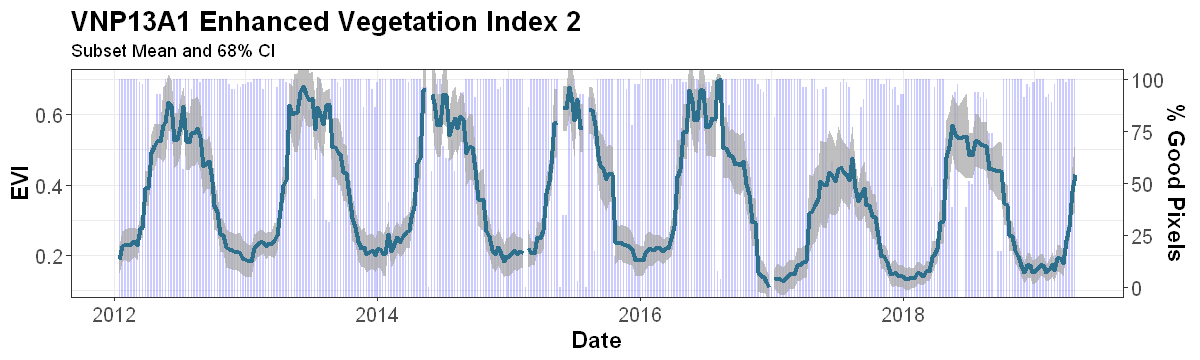

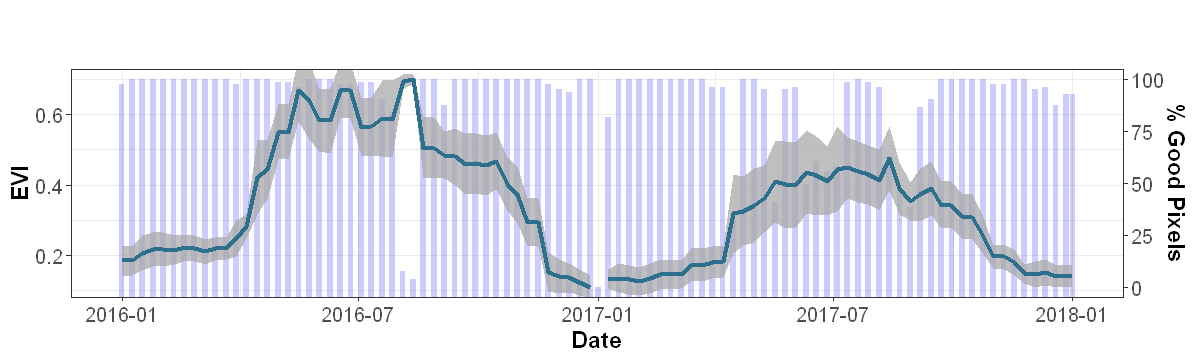

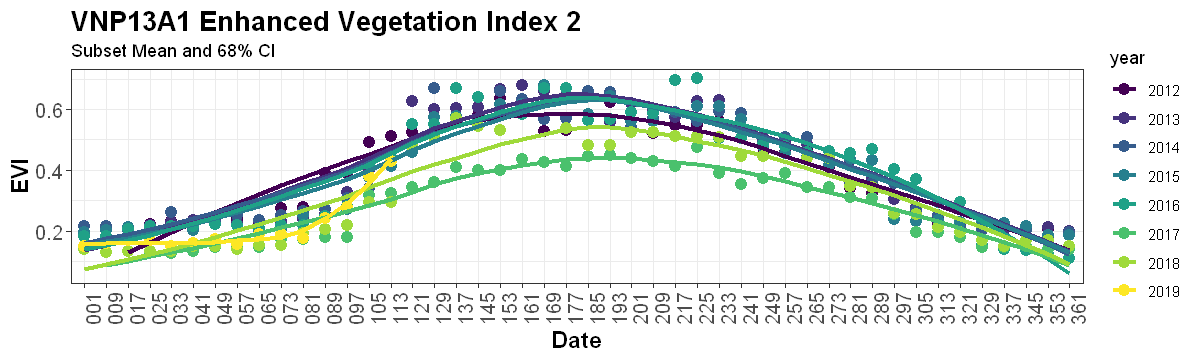

In [17]:
prodvalues <- prodvalues*as.numeric(scale) # Apply scale factor
pltdate <- unlist(calendar_dates)

prodstats <- data.frame(
    date = as.Date(pltdate),
    year = substr(pltdate,start=1,stop=4),
    doy = substr(unlist(modis_dates),start=6,stop=8),
    mean = rowMeans(prodvalues, na.rm=TRUE), 
    sd = apply(prodvalues, 1, sd, na.rm = TRUE),
    quality = apply(prodvalues, 1, function(x) sum(!is.na(x))/(nrow*ncol)*100))
                    
# Get min and max of the calculated means
meanMax <- max(prodstats$mean, na.rm = TRUE)
meanMin <- min(prodstats$mean, na.rm = TRUE)     
# Create simple function to scale the quality values to the mean values for plotting
scaleq <- function(x){((x-0)/(100-0))*(meanMax-meanMin)+meanMin}

# find the 68% confidence intervals around the mean
y1 <- prodstats$mean + prodstats$sd 
y2 <- prodstats$mean - prodstats$sd

plot3 <- ggplot(prodstats) +
    # Data quality
    geom_col(aes(y=scaleq(prodstats$quality), x=date), fill= 'blue', alpha = 0.2) +
    scale_y_continuous(limits = c(meanMin, meanMax), oob = rescale_none, sec.axis = sec_axis(~((. - meanMin)/(meanMax - meanMin))*100, name = "% Good Pixels")) +
                    
    # LST mean and sd
    geom_ribbon(aes(ymin=y2, ymax=y1, x=date), fill = 'darkgray', alpha = 0.75) + # draw the shaded area for 68% CI
    geom_line(aes(y=mean, x=date), colour = '#2D708EFF', size=1.2) + # draw the line for the mean value  
    
    labs(title = 'VNP13A1 Enhanced Vegetation Index 2', subtitle = 'Subset Mean and 68% CI') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements

plot5 <- ggplot(prodstats, aes(x=doy, y=mean, color=year)) + 
    scale_color_viridis(discrete=T) + 
    geom_point(size=3) + 
    geom_smooth(aes(group=year), method = 'loess', se=FALSE, size=1.2) + 
    labs(title = 'VNP13A1 Enhanced Vegetation Index 2', subtitle = 'Subset Mean and 68% CI') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12, angle=90), 
        axis.text.y = element_text(size=12)) # set optional theme elements                  
                    
prodstats2 <- prodstats[prodstats$date %in% pltdate[which(pltdate == '2016-01-01'):which(pltdate == '2018-01-01')],]
meanMax2 <- max(prodstats2$mean, na.rm = TRUE)
meanMin2 <- min(prodstats2$mean, na.rm = TRUE)     
plot4 <- ggplot(prodstats2) +
    # Data quality
    geom_col(aes(y=(((prodstats2$quality-0)/(100-0))*(meanMax2-meanMin2)+meanMin2), x=date), fill= 'blue', alpha = 0.2) +
    scale_y_continuous(limits = c(meanMin2, meanMax2), oob = rescale_none, sec.axis = sec_axis(~((. - meanMin2)/(meanMax2 - meanMin2))*100, name = "% Good Pixels")) +
    # LST mean and sd
    geom_ribbon(aes(ymin=(prodstats2$mean - prodstats2$sd), ymax=(prodstats2$mean + prodstats2$sd), x=date), fill = 'darkgray', alpha = 0.75) + # draw the shaded area for 68% CI
    geom_line(aes(y=mean, x=date), colour = '#2D708EFF', size=1.2) + # draw the line for the mean value  
    labs(title = ' ', subtitle = ' ') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements
                    
        
options(repr.plot.width = 10, repr.plot.height = 3)
plot3
plot4
plot5

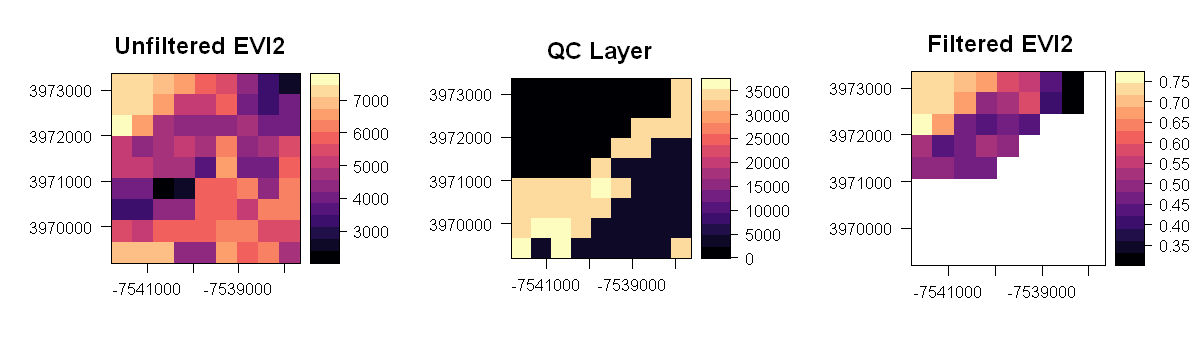

In [18]:
# Get array of unfiltered product values
array_nofilter <- t(as.data.frame(proddata[proddata$calendar_date == "2018-06-26",'data'], check.names=FALSE))
array_nofilter[array_nofilter == 0] <- NA # Remove fill cells
# Get array of QC values
array_qc <- qcvalues["2018-06-26",]
# Get array filtered LST values
array_filter <- prodvalues["2018-06-26",]

# Make a raster object from each array
r_nofilter <- r_template(array_nofilter, nrow, ncol, xllcorner, yllcorner, cellsize)
r_qc <- r_template(array_qc, nrow, ncol, xllcorner, yllcorner, cellsize)
r_filter <- r_template(array_filter, nrow, ncol, xllcorner, yllcorner, cellsize)

# Plot them with rasterVis::levelplot
r1 <- levelplot(r_nofilter, main = "Unfiltered EVI2", margin = FALSE)
r2 <- levelplot(r_qc, main = "QC Layer", margin = FALSE)
r3 <- levelplot(r_filter, main = "Filtered EVI2", margin = FALSE)

# Print them with gridExtra::grid.arrange
grid.arrange(r1, r2, r3, ncol=3)

In [19]:
#Time series by land cover type
r <- GET(request_url <- requestURL(lat, lon, 'MCD12Q1', 'LC_Type1', "A2016001", "A2016001", above_below, left_right))

lcsubset <- fromJSON(toJSON(content(r)))

saveRDS(lcsubset$subset, file = "D:/data/lcdata.rds")

lcdata <- readRDS(file = "D:/data/lcdata.rds")
# Format as "CSV-like" data frame
lcvalues <- t(as.data.frame(lcdata$data, col.names=lcdata$calendar_date, check.names=FALSE))
lcvalues


2016-01-01,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [20]:
lctab <- "
Value,LCType,Color
1,Evergreen Needleleaf Forest,#008000
2,Evergreen Broadleaf Forest,#00FF00
3,Deciduous Needleleaf Forest,#99CC00
4,Deciduous Broadleaf Forest,#99FF99
5,Mixed Forests,#339966
6,Closed Shrublands,#993366
7,Open Shrublands,#FFCC99
8,Woody Savannas,#CCFFCC
9,Savannas,#FFCC00
10,Grasslands,#FF9900
11,Permanent Wetlands,#006699
12,Croplands,#FFFF00
13,Urban and Built-Up,#FF0000
14,Cropland/Natural Vegetation Mosaic,#999966
15,Snow and Ice,#FFFFFF
16,Barren or Sparsely Vegetated,#808080
17,Water Bodies,#000080
255,Unclassified,#000000
"
lctab <- read.csv(text = lctab, header = TRUE, stringsAsFactors = FALSE)
lctab

Value,LCType,Color
1,Evergreen Needleleaf Forest,#008000
2,Evergreen Broadleaf Forest,#00FF00
3,Deciduous Needleleaf Forest,#99CC00
4,Deciduous Broadleaf Forest,#99FF99
5,Mixed Forests,#339966
6,Closed Shrublands,#993366
7,Open Shrublands,#FFCC99
8,Woody Savannas,#CCFFCC
9,Savannas,#FFCC00
10,Grasslands,#FF9900


In [21]:
# Initialize data frame with a column for each land cover type
lcmeans <- data.frame(matrix(ncol = length(unique(lctab$Value)), nrow = 0))
colnames(lcmeans) <- c(lctab$LCType)

# Loop through timesteps
for(tstep in seq(1, length(calendar_dates), by = 1)){
    # Get mean of pixels matching each land cover type for that year and append to lcmeans
    tstepmeans = lapply(lctab$Value, function(type) mean(prodvalues[tstep,][which(lcvalues[1,] %in% type)], na.rm = TRUE))
    lcmeans[tstep,] <- unlist(tstepmeans)
}

# Add Date column to lcmeans
rownames(lcmeans) <- calendar_dates
lcmeans <- lcmeans[,colSums(is.na(lcmeans))<nrow(lcmeans)]
lcmeans$Date <- as.Date(rownames(lcmeans))
                            
head(lcmeans, 5)

,Deciduous Broadleaf Forest,Woody Savannas,Urban and Built-Up,Date
2012-01-17,0.1859762,0.1862000,0.1941667,2012-01-17
2012-01-25,0.2241921,0.2161667,0.2224833,2012-01-25
2012-02-02,0.2329032,0.2114667,0.2258833,2012-02-02
2012-02-10,0.2311365,0.2097667,0.2137667,2012-02-10
2012-02-18,0.2321746,0.2220500,0.2257250,2012-02-18


Note that "reshape::melt" requires to install a package called "reshape", not installed at the begginig.  So make sure to install such package, load the libarary and tun the next cell.  You may need to install this library directly on R before the plot5

In [22]:
# Use reshape::melt to convert table to long format:



lcmeans_long <- reshape::melt(lcmeans, id.vars="Date")

plot5 <- ggplot(na.omit(lcmeans_long), aes(x = as.Date(Date), y=value, color=variable)) + 
    scale_color_viridis(discrete=T) + 
    geom_line(aes(group=variable), size=1.2) +
    labs(title = 'VIIRS EVI2 (VNP13A1) by Land Cover Type (MCD12Q1)') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(
        plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements

plot5

Installing package into 'C:/Users/janaya/Documents/R/win-library/3.5'
(as 'lib' is unspecified)


ERROR: Error in contrib.url(repos, "source"): trying to use CRAN without setting a mirror


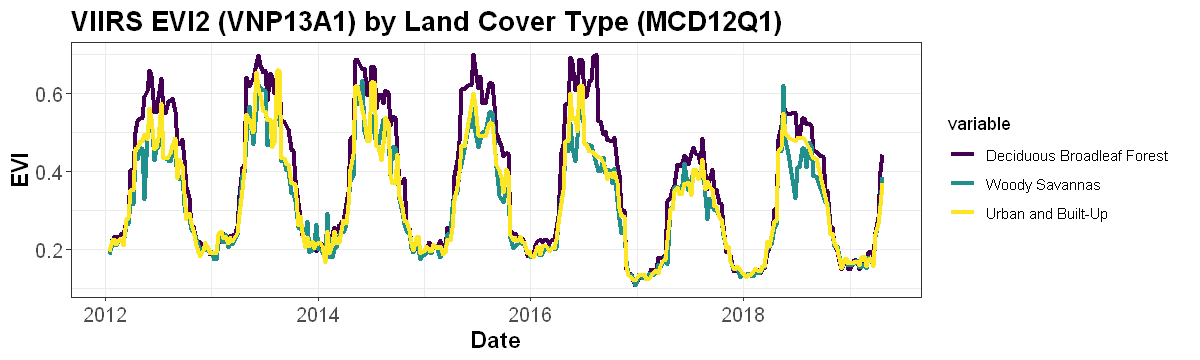

In [23]:
lcmeans_long <- reshape::melt(lcmeans, id.vars="Date")

plot5 <- ggplot(na.omit(lcmeans_long), aes(x = as.Date(Date), y=value, color=variable)) + 
    scale_color_viridis(discrete=T) + 
    geom_line(aes(group=variable), size=1.2) +
    labs(title = 'VIIRS EVI2 (VNP13A1) by Land Cover Type (MCD12Q1)') +
    ylab('EVI') + # add a y-axis label
    xlab("Date") + # add a x-axis label
    theme_bw() + # set the plot theme
    theme(
        plot.title = element_text(lineheight=.8, face="bold", size=16), 
        axis.title.x = element_text(face="bold", size=14), 
        axis.title.y = element_text(face="bold", size=14), 
        axis.text.x = element_text(size=12), 
        axis.text.y = element_text(size=12)) # set optional theme elements

plot5